<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [2]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

from scipy.stats import bernoulli, beta 

from bayes import *

In [3]:
# datos

df = pd.read_csv('data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.shape

(90189, 5)

In [5]:
df['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

### TESTEO PARA RETENCIÓN A 1 DÍA

In [13]:
#impresiones en el grupo control
imps_ctrl = df[(df['version'] == 'gate_30')] 
len(imps_ctrl)

44700

In [15]:
#conversiones en el grupo control a 1 día
convs_ctrl = df[(df['version'] == 'gate_30') & (df['retention_1'] == True)]
len(convs_ctrl)

20034

In [16]:
# Impresiones en el grupo test
imps_test = df[(df['version'] == 'gate_40')]
len(imps_test)

45489

In [17]:
# Conversiones en el grupo test a 1 día
convs_test = df[(df['version'] == 'gate_40') & (df['retention_1'] == True)]
len(convs_test)

20119

In [18]:
imps_ctrl, convs_ctrl = 44700, 20034
imps_test, convs_test = 45489, 20119

CR_ctrl = convs_ctrl/imps_ctrl # tasa de conversion control
CR_test = convs_test/imps_test # tasa de conversion test

f'Tasas conversion: Grupo Control: {CR_ctrl}, Grupo Test: {CR_test}'

'Tasas conversion: Grupo Control: 0.4481879194630872, Grupo Test: 0.44228274967574577'

In [20]:
# A priori
a_C = 1+convs_ctrl   #Se añade 1 al número de conversiones en el grupo de control.
b_C = 1+imps_ctrl-convs_ctrl  #Se añade 1 al número total de impresiones menos el número de conversiones en el grupo de control.

a_T = 1+convs_test  #Se añade 1 al número de conversiones en el grupo de prueba
b_T = 1+imps_test-convs_test # Se añade 1 al número total de impresiones menos el número de conversiones en el grupo de prueba

#se crean objetos de distribución beta 
beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)

In [21]:
#vemos las medias
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

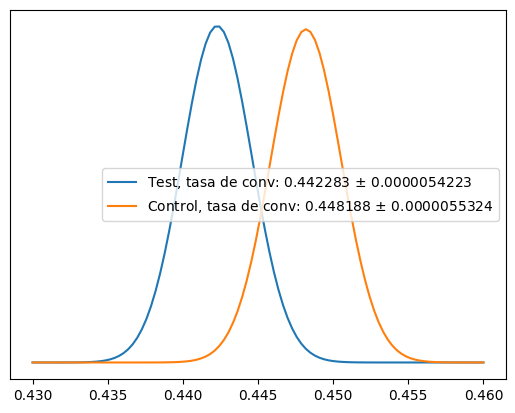

In [24]:
#lo vemos en el gráfico
def plot(betas, names, linf=0.43, lsup=0.46):
    x = np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y = f.pdf(x)
        y_pico = pico(f.args[0], f.args[1])
        y_var = f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();
    
plot([beta_test,beta_control],['Test','Control'])

In [25]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()

salto

0.013175098158249857

In [27]:
prob = calc_prob(beta_control, beta_test)
prob

0.962793974846091

In [28]:
'''El Control aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El Control aumenta la tasa de conversion en un 1.32%, con una probabilidad del 96.28%'

### TESTEO PARA RETENCIÓN A 7 DÍAS

In [29]:
#conversiones en el grupo control a 7 días
convs_ctrl = df[(df['version'] == 'gate_30') & (df['retention_7'] == True)]
len(convs_ctrl)

8502

In [30]:
# Conversiones en el grupo test a 7 díaS
convs_test = df[(df['version'] == 'gate_40') & (df['retention_7'] == True)]
len(convs_test)

8279

In [31]:
imps_ctrl, convs_ctrl = 44700, 8502 
imps_test, convs_test = 45489, 8279

CR_ctrl = convs_ctrl/imps_ctrl # tasa de conversion control
CR_test = convs_test/imps_test # tasa de conversion test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [32]:
a_C = 1+convs_ctrl   #Se añade 1 al número de conversiones en el grupo de control.
b_C = 1+imps_ctrl-convs_ctrl  #Se añade 1 al número total de impresiones menos el número de conversiones en el grupo de control.

a_T = 1+convs_test  #Se añade 1 al número de conversiones en el grupo de prueba
b_T = 1+imps_test-convs_test # Se añade 1 al número total de impresiones menos el número de conversiones en el grupo de prueba

#se crean objetos de distribución beta 
beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)

In [35]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

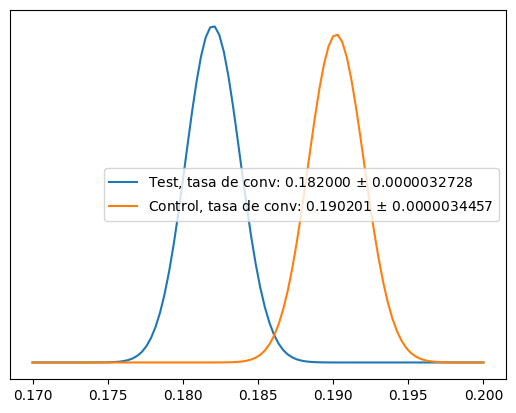

In [34]:
def plot(betas, names, linf=0.17, lsup=0.2):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();beta_control.mean(), beta_test.mean()
    
plot([beta_test,beta_control,],['Test','Control'])    

In [36]:
salto = (beta_control.mean() - beta_test.mean())/beta_control.mean()

salto


0.04311526114658881

In [37]:
prob = calc_prob(beta_control, beta_test)
prob

0.9992226613159454

In [38]:
'''El Control aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)


'El Control aumenta la tasa de conversion en un 4.31%, con una probabilidad del 99.92%'

In [ ]:
# conclusiones
# Según los resultados obtenidos, el grupo control (gate30) es el que tiene mayor tasa de conversión tanto a 1 como a 7 días. 
# En otras palabras, no se aconseja pasar la puerta al nivel 40